## Import libraries

In [16]:
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.functions import bollinger_strategy
from scipy import stats

## Functions to get, manipulate and plot data

In [17]:
def get_data(filename, q_learning=False):
    with open(filename, 'rb') as handle:
        output_dict = pickle.load(handle)
    scores = output_dict["scores"]
    data = output_dict["data"]
    setting = output_dict["setting"]
    if q_learning:
        return scores, data, setting, output_dict["q_tabular"]
    return scores, data, setting

def get_moving_avg(scores, window_size):
    numbers_series = pd.Series(scores)
    windows = numbers_series.rolling(window_size, min_periods=1)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    return moving_averages_list, [i for i in range(1,len(moving_averages_list)+1)]

def get_moving_std(scores, window_size):
    numbers_series = pd.Series(scores)
    windows = numbers_series.rolling(window_size, min_periods=1)
    moving_averages = windows.std()
    moving_averages_list = moving_averages.tolist()
    return moving_averages_list, [i for i in range(1,len(moving_averages_list)+1)]

def plot_avg(x_q, scores_q_avg, x_idqn, scores_idqn_avg,
             x_dqn, scores_dqn_avg, x_bb, scores_bb_avg):
    plt.plot(x_q, scores_q_avg, color="red", label="Q-Learning")
    plt.plot(x_idqn, scores_idqn_avg, color="blue", label="Interactive DQN")
    plt.plot(x_dqn, scores_dqn_avg, color="orange", label="DQN")
    plt.plot(x_bb, scores_bb_avg, color="green", label="Bollinger Bands")

    plt.legend(loc= "lower right", fontsize=13)
    plt.ylabel("PnL", fontsize=15)
    plt.xlabel("Episode", fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("Moving Average of PnL for One L/S Agents",
              fontsize=16)
    plt.show()

def plot_std(x_q, scores_q_std, x_idqn, scores_idqn_std,
             x_dqn, scores_dqn_std,x_bb, scores_bb_std):
    plt.plot(x_q, scores_q_std, color="red", label="Q-Learning")
    plt.plot(x_idqn, scores_idqn_std, color="blue", label="Interactive DQN")
    plt.plot(x_dqn, scores_dqn_std, color="orange", label="DQN")
    plt.plot(x_bb, scores_bb_std, color="green", label="Bollinger Bands")

    plt.legend(loc= "upper right", fontsize=13)
    plt.ylabel("Standard Deviation", fontsize=15)
    plt.xlabel("Episode", fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("Moving Standard Deviation of PnL for One L/S Agents",
              fontsize=16)
    plt.show()

## Set up Bollinger bands as a benchmark

In [18]:
theta = 10.
mu = 0.
sigma = .20

T = 10.
N = 100
ts = np.linspace(0., T, N)
num_iter = 2_500
pnlss = bollinger_strategy(theta, mu, sigma, ts, num_iter)
scores_bb = [pnls[-1] for pnls in pnlss]

## Plot and compare PnL of Agents:
- Q learning
- Interactive Deep Q Network
- Normal Deep Q Network

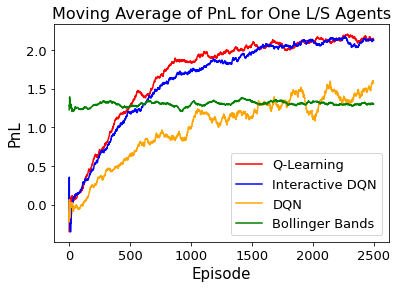

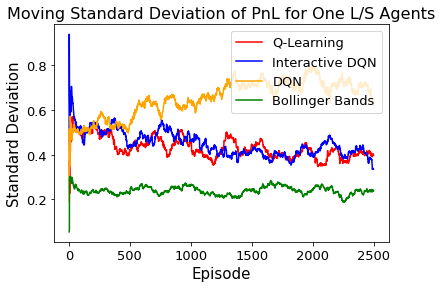

In [19]:
path = os.path.dirname(os.path.dirname(os.getcwd()))
filename_q = path + '\data\q_learning\q_learning_output.pickle'
filename_idqn = path + '\data\interactive_dqn\interactive_dqn_output.pickle'
filename_dqn = path + '\data\dqn\dqn_output.pickle'

window_size = 100

scores_q, data_q, setting_q, q_tabular = get_data(filename_q, True)
scores_idqn, data_idqn, setting_idqn = get_data(filename_idqn, False)
scores_dqn, data_dqn, setting_dqn = get_data(filename_dqn, False)

scores_q_avg, x_q = get_moving_avg(scores_q, window_size)
scores_idqn_avg, x_idqn = get_moving_avg(scores_idqn, window_size)
scores_dqn_avg, x_dqn = get_moving_avg(scores_dqn, window_size)
scores_bb_avg, x_bb = get_moving_avg(scores_bb, window_size)

scores_q_std, _ = get_moving_std(scores_q, window_size)
scores_idqn_std, _ = get_moving_std(scores_idqn, window_size)
scores_dqn_std, _ = get_moving_std(scores_dqn, window_size)
scores_bb_std, _ = get_moving_std(scores_bb, window_size)

plot_avg(x_q, scores_q_avg, x_idqn, scores_idqn_avg, x_dqn, scores_dqn_avg, x_bb, scores_bb_avg)
plot_std(x_q, scores_q_std, x_idqn, scores_idqn_std, x_dqn, scores_dqn_std, x_bb, scores_bb_std)

## Functions for Decision Splitting Plots

In [20]:
def data_prep(data, dir, upper, lower):
    df = data[data["decision"]==str(dir)]
    data_temp = df[df["episode"]<=upper]
    data_temp_1 = data_temp[data_temp["episode"]>=lower]
    y = data_temp_1["price"].values
    kernel = stats.gaussian_kde(y)
    x_kde = np.linspace(min(y), max(y), 100)
    return y, kernel(x_kde), x_kde

def data_prep_loop(data, episodal_center= [50, 450, 1450], window_half = 50):
    y_s = []
    y_b = []
    y_kde_s = []
    y_kde_b = []
    x_kde_s = []
    x_kde_b = []
    for i in range(len(episodal_center)):
        upper = episodal_center[i] + window_half
        lower = episodal_center[i] - window_half
        y1, y_kde1, x_kde1 = data_prep(data, "s", upper, lower)
        y2, y_kde2, x_kde2 = data_prep(data, "b", upper, lower)
        y_s.append(y1)
        y_b.append(y2)
        y_kde_s.append(y_kde1)
        y_kde_b.append(y_kde2)
        x_kde_s.append(x_kde1)
        x_kde_b.append(x_kde2)

    return y_s, y_b, y_kde_s, y_kde_b ,x_kde_s ,x_kde_b

def decision_splitting(data, episodal_center, window_half, agent, dist=1):
    y_s, y_b, y_kde_s, y_kde_b ,x_kde_s ,x_kde_b = data_prep_loop(data, episodal_center, window_half)
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,5))

    axs[0][0].plot(x_kde_b[0], y_kde_b[0], color="green")
    axs[0][0].hist(y_b[0], density=True, bins=100, color="green", alpha=0.5, label="Short to Long")
    axs[0][0].plot(x_kde_s[0], y_kde_s[0], color="red")
    axs[0][0].hist(y_s[0], density=True, bins=100, color="red", alpha=0.5, label="Long to Short")
    axs[0][0].legend(loc= "upper right", fontsize=12)
    axs[0][0].text(np.amin(y_b[0])*dist,10, 'Episodes ' + str(episodal_center[0]-window_half) +
                '-' + str(episodal_center[0]+window_half), fontsize=15)

    axs[0][1].plot(x_kde_b[1], y_kde_b[1], color="green")
    axs[0][1].hist(y_b[1], density=True, bins=100, color="green", alpha=0.5)
    axs[0][1].plot(x_kde_s[1], y_kde_s[1], color="red")
    axs[0][1].hist(y_s[1], density=True, bins=100, color="red", alpha=0.5)
    #axs[0][1].legend(loc= "upper right", fontsize=12)
    axs[0][1].text(np.amin(y_b[0])*dist,10, 'Episodes ' + str(episodal_center[1]-window_half) +
                '-' + str(episodal_center[1]+window_half), fontsize=15)

    axs[1][0].plot(x_kde_b[2], y_kde_b[2], color="green")
    axs[1][0].hist(y_b[2], density=True, bins=100, color="green", alpha=0.5)
    axs[1][0].plot(x_kde_s[2], y_kde_s[2], color="red")
    axs[1][0].hist(y_s[2], density=True, bins=100, color="red", alpha=0.5)
    #axs[1][0].legend(loc= "upper right", fontsize=12)
    axs[1][0].text(np.amin(y_b[0])*dist,10, 'Episodes ' + str(episodal_center[2]-window_half) +
                '-' + str(episodal_center[2]+window_half), fontsize=15)

    axs[1][1].plot(x_kde_b[3], y_kde_b[3], color="green")
    axs[1][1].hist(y_b[3], density=True, bins=100, color="green", alpha=0.5)
    axs[1][1].plot(x_kde_s[3], y_kde_s[3], color="red")
    axs[1][1].hist(y_s[3], density=True, bins=100, color="red", alpha=0.5)
    #axs[1][1].legend(loc= "upper right", fontsize=12)
    axs[1][1].text(np.amin(y_b[0])*dist,10, 'Episodes ' + str(episodal_center[3]-window_half) +
                '-' + str(episodal_center[3]+window_half), fontsize=15)

    axs[0][0].set_title('Action Splitting of ' + str(agent) + ' Agent', fontsize=18)
    axs[0][1].set_title('Action Splitting of ' + str(agent) + ' Agent', fontsize=18)
    axs[1][0].set_ylabel('Density', fontsize=17)
    axs[0][0].set_ylabel('Density', fontsize=17)
    axs[1][0].set_xlabel('Stock price', fontsize=17)
    axs[1][1].set_xlabel('Stock price', fontsize=17)
    fig.tight_layout()

    plt.show()

## Q Learning
#### Setting:

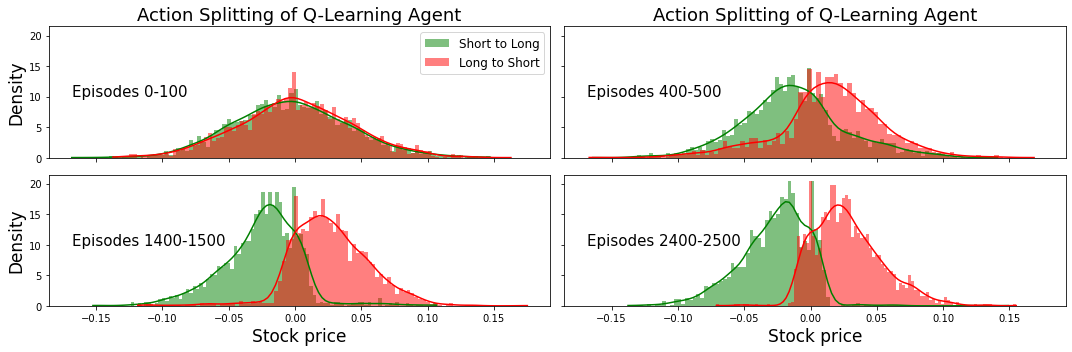

In [21]:
episodal_center = [50, 450, 1450, 2450]
window_half = 50
decision_splitting(data_q, episodal_center, window_half, "Q-Learning", 1)

## Interactive Deep Q Learning

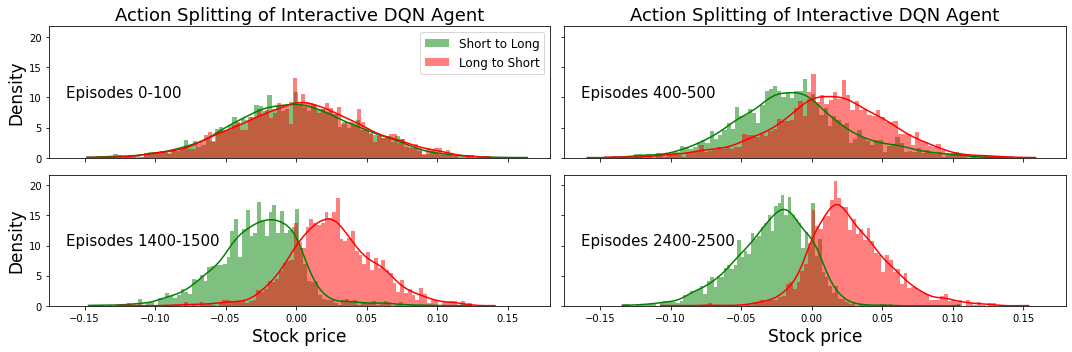

In [22]:
decision_splitting(data_idqn, episodal_center, window_half, "Interactive DQN", 1.1)

## Normal Deep Q Learning

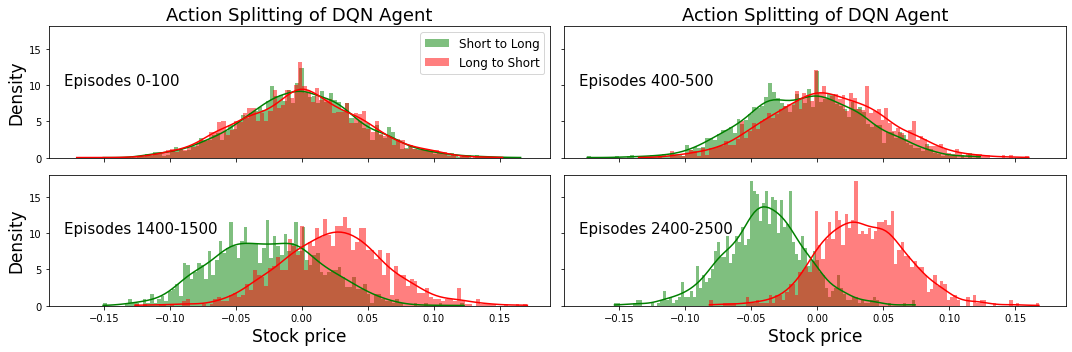

In [23]:
decision_splitting(data_dqn, episodal_center, window_half, "DQN", 1.2)

## Function Q-tabular plot

In [24]:
def q_tab(q_tabular):
    pos_exp=[]
    pos_n = []
    sell = []
    neg_exp=[]
    neg_n = []
    buy = []
    for key in q_tabular.keys():
        if int(key) < 0:
            neg_exp.append(int(key))
            neg_n.append(q_tabular[key]["n"])
            buy.append(q_tabular[key]["b"])
        else:
            pos_exp.append(int(key))
            pos_n.append(q_tabular[key]["n"])
            sell.append(q_tabular[key]["s"])
    return pos_exp, pos_n, sell, neg_exp, neg_n, buy

def plot_q_tab(q_tabular):
    pos_exp, pos_n, sell, neg_exp, neg_n, buy = q_tab(q_tabular)
    fig, axs = plt.subplots(2, 1, sharey=True, figsize=(15,5))
    axs[0].scatter(pos_exp, sell, color="red", label="Long to Short")
    axs[0].scatter(pos_exp, pos_n, color="orange", label="Nothing")
    axs[0].legend(loc="center left", fontsize=15)

    axs[1].scatter(neg_exp, buy, color="green", label="Short to Long")
    axs[1].scatter(neg_exp, neg_n, color="orange", label="Nothing")
    axs[1].legend(loc="center left", fontsize=15)

    axs[0].set_ylabel("Q(s,a)", fontsize=22)
    axs[1].set_ylabel("Q(s,a)", fontsize=22)
    axs[1].set_xlabel("State", fontsize=22)
    axs[0].set_title("Q-values for all State-Action pairs", fontsize=24)
    fig.tight_layout()
    plt.show()

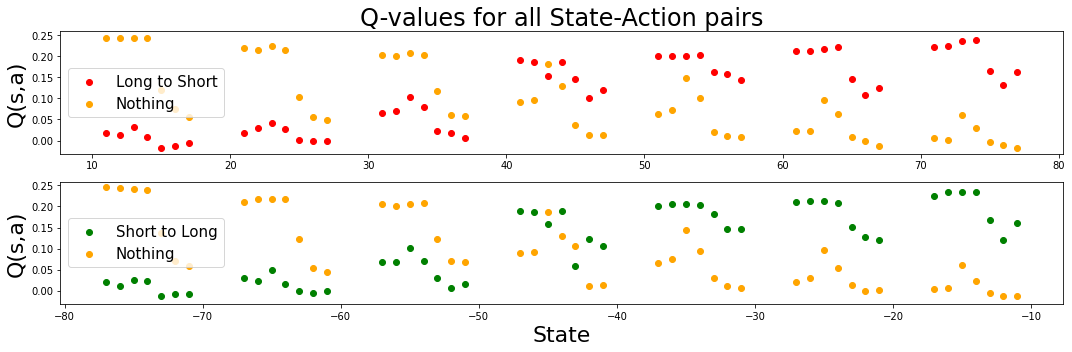

In [25]:
plot_q_tab(q_tabular)

## Function to Plot single process

In [26]:
def recreate_pnl(data):
    pnls=[0]
    cash = 0
    pnl = 0

    Xs = data["price"].values
    action = data["decision"].values
    cur_exp = []
    states = data["states"].values

    for i in range(len(data)):
        if int(states[i])>0:
            cur_exp.append(1)
        else:
            cur_exp.append(-1)

    for i in range(len(data)-1):
        if action[i] == "s":
            cash += 2 * Xs[i]
            pnl = cash - Xs[i + 1]
        elif action[i] == "b":
            cash -= 2 * Xs[i]
            pnl = cash + Xs[i + 1]
        else:
            if cur_exp[i] == 1:
                pnl = cash - Xs[i + 1] + Xs[i]
            elif cur_exp[i] == -1:
                pnl = cash + Xs[i + 1] - Xs[i]
            else:
                print("Unknown exposure")
        pnls.append(pnl)
    return pnls

def plot_episodes(data, episodes=[1,2500]):
    df = data[data["episode"] == episodes[0]-1]
    pnls = recreate_pnl(df)
    df_s = df[df["decision"]=="s"]
    df_b = df[df["decision"]=="b"]

    fig, ax = plt.subplots(1,2 ,sharey=True, figsize=(15,5))

    ax[0].plot(df["time"] - min(df["time"]), df["price"], color="grey", alpha=0.5, label="Price process")
    ax[0].scatter(df_s["time"] - min(df["time"]), df_s["price"], color="red", label="Long to Short",
                marker= "v", s=100)
    ax[0].scatter(df_b["time"] - min(df["time"]), df_b["price"], color="green", label="Short to Long",
                marker= "^", s=100)
    ax[0].set_xlabel("Time", fontsize=15)
    ax[0].set_ylabel("Ornstein-Uhlenbeck process", fontsize=18)
    ax[0].set_title("Episode " + str(episodes[0]), fontsize=16)
    ax[0].legend(loc="lower left",fontsize=13)

    ax1 = ax[0].twinx()
    ax1.plot(df["time"] - min(df["time"]), pnls, color="black", label="PnL",linewidth=2)
    ax1.set_ylim((-3,2.5))
    ax1.set_yticks([])
    ax1.legend(loc="upper left",fontsize=13)

    df = data[data["episode"] == episodes[1]-1]
    pnls = recreate_pnl(df)
    df_s = df[df["decision"]=="s"]
    df_b = df[df["decision"]=="b"]

    ax[1].plot(df["time"] - min(df["time"]), df["price"], color="grey", alpha=0.5, label="Price process")
    ax[1].scatter(df_s["time"] - min(df["time"]), df_s["price"], color="red", label="Long to Short",
                marker= "v", s=100)
    ax[1].scatter(df_b["time"] - min(df["time"]), df_b["price"], color="green", label="Short to Long",
                marker= "^", s=100)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].set_title("Episode " + str(episodes[1]), fontsize=16)
    #ax[1].legend(loc="lower left", fontsize=13)

    ax2 = ax[1].twinx()
    ax2.plot(df["time"] - min(df["time"]), pnls, color="black", label="PnL",linewidth=2)
    ax2.set_ylabel("PnL", fontsize=15)
    #ax2.legend(loc="upper left", fontsize=13)
    ax2.set_ylim((-3,2.5))
    plt.tight_layout()
    plt.show()

## Compare Investment process of two episodes

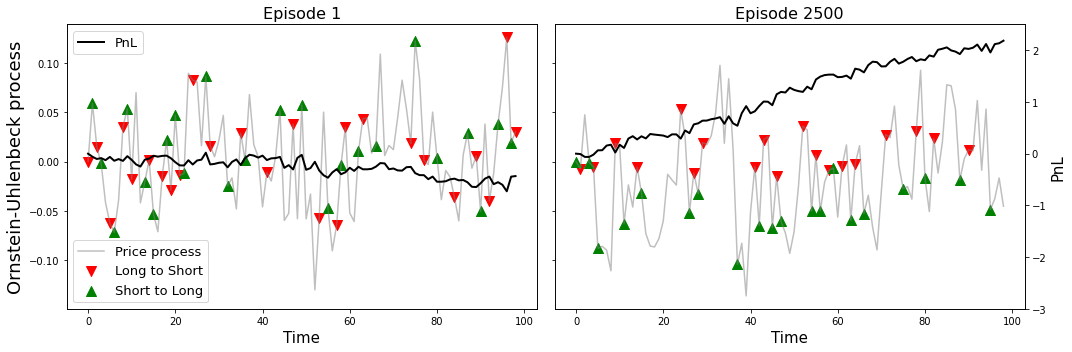

In [27]:
plot_episodes(data_q)

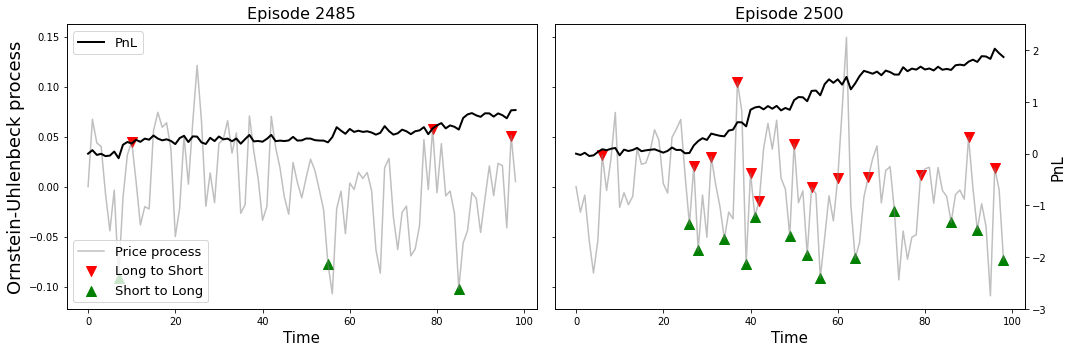

In [28]:
plot_episodes(data_dqn, episodes=[2485, 2500])

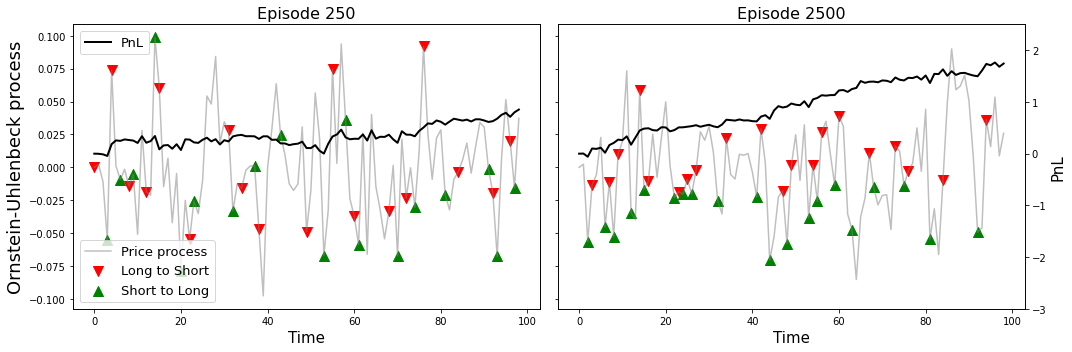

In [29]:
plot_episodes(data_idqn, episodes=[250, 2500])

## Function to gather Statistics of the different Agents

In [30]:
def stats_gatherer(data, scores, name, episodes):
    print(str(name))
    result_dict = {}
    for tuple in episodes:
        temp_dict = {}
        df = data[data["episode"] >= tuple[0]]
        df_1 = df[df["episode"] < tuple[1]]
        numb = len(df_1[df_1["decision"] != "n"])
        scores_1 = scores[tuple[0]:tuple[1]]

        temp_dict["Avg_PnL"]= np.mean(scores_1)
        temp_dict["Std_PnL"]= np.std(scores_1)
        temp_dict["Med_PnL"]= np.quantile(scores_1, 0.5)
        temp_dict["inv_per_episode"] = numb/ (tuple[1]-tuple[0])
        temp_dict["profit_per_exp_change"] = np.sum(scores_1)/numb

        print(temp_dict)

        result_dict[str(tuple)] = temp_dict
    return result_dict




In [31]:
episodes = [(0,100), (400,500), (1400,1500), (2000,2100), (2400,2500)]
result_q = stats_gatherer(data_q, scores_q, "Q Learning",
                          episodes= episodes)
result_dqn = stats_gatherer(data_dqn, scores_dqn, "DQN",
                          episodes= episodes)
result_idqn = stats_gatherer(data_idqn, scores_idqn, "Interactive DQN",
                          episodes= episodes)

Q Learning
{'Avg_PnL': 0.16712080284231004, 'Std_PnL': 0.48391379318362987, 'Med_PnL': 0.16620182755569277, 'inv_per_episode': 49.46, 'profit_per_exp_change': 0.0033789082661202998}
{'Avg_PnL': 1.2840387459657723, 'Std_PnL': 0.41833067840862653, 'Med_PnL': 1.3058987463171787, 'inv_per_episode': 46.51, 'profit_per_exp_change': 0.027607799311239998}
{'Avg_PnL': 2.068680076087173, 'Std_PnL': 0.44176653125024096, 'Med_PnL': 2.077919471978498, 'inv_per_episode': 39.61, 'profit_per_exp_change': 0.05222620742456887}
{'Avg_PnL': 2.112875262624951, 'Std_PnL': 0.35418029377452753, 'Med_PnL': 2.0676605884590433, 'inv_per_episode': 39.09, 'profit_per_exp_change': 0.05405155442888081}
{'Avg_PnL': 2.1380970231647045, 'Std_PnL': 0.39563875860793923, 'Med_PnL': 2.1023109018323867, 'inv_per_episode': 38.64, 'profit_per_exp_change': 0.0553337738914261}
DQN
{'Avg_PnL': -0.006139183019429897, 'Std_PnL': 0.49161373986526824, 'Med_PnL': -0.0487184909066357, 'inv_per_episode': 49.15, 'profit_per_exp_change':